# Age Classification Model

## 1. Investigating dataset

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import random

D:\Documents\Personal Projects\Age_Predictor\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("prithivMLmods/Age-Classification-Set")

In [3]:
labels = ds["train"].features["label"].names
label_mapping = {i: v for i, v in enumerate(labels)}
label_mapping

{0: '0-12', 1: '13-20', 2: '21-44', 3: '45-64', 4: '65+'}

In [4]:
ds = ds["train"]
print(ds)
print(len(ds))

Dataset({
    features: ['image', 'label'],
    num_rows: 19016
})
19016


In [ ]:
ds[0]["label"], ds[0]["image"]

In [ ]:
def print_samples():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
    axes = axes.flatten()
    ind = random.sample(range(len(ds)), 1)[0]
    for ax in axes:
        ax.imshow(ds[ind]['image'])
        ax.set_title(label_mapping[ds[ind]['label']])
        ind = random.sample(range(len(ds)), 1)[0]
    plt.tight_layout()  # Adjust the layout to prevent titles and labels from overlapping
    plt.show()
print_samples()

### Structure dataset folder for YOLO

Split data into "train", "eval", "test"

First we need to find indices of each age group

In [5]:
from tqdm import tqdm

indices_by_class = {}

for ind, sample in tqdm(enumerate(ds), total=len(ds), desc="Detecting indices of each age group"):
    cls = label_mapping[sample['label']]
    if cls not in indices_by_class:
        indices_by_class[cls] = []
    indices_by_class[cls].append(ind)

Detecting indices of each age group: 100%|██████████| 19016/19016 [00:31<00:00, 600.61it/s]


In [6]:
for cls, indices in indices_by_class.items():
    print(f"{cls}:   {len(indices)} samples")

0-12:   2193 samples
13-20:   1779 samples
21-44:   9999 samples
45-64:   3785 samples
65+:   1260 samples


Because the number of `21-44` group is exceeded, we randomly reduce the number of these images to 4000 samples (comparable to the second most class in the dataset).

In [ ]:
import random
random.seed(42)

num_sample_remain = 4000

indices_by_class["21-44"] = random.sample(indices_by_class["21-44"], k=num_sample_remain)

In [ ]:
len(indices_by_class["21-44"])

In [ ]:
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1

ds_indices = {
    'train': [],
    'val': [],
    'test': []
}

for age, indices in indices_by_class.items():
    print(f"Splitting dataset for {age} group...")

    num_train_samples = int(TRAIN_RATIO * len(indices))
    num_validation_samples = int(VALIDATION_RATIO * len(indices))

    random.shuffle(indices)
    train_indices = indices[:num_train_samples]
    validation_indices = indices[num_train_samples:num_train_samples + num_validation_samples]
    test_indices = indices[num_train_samples + num_validation_samples:]

    ds_indices["train"] += train_indices
    ds_indices["val"] += validation_indices
    ds_indices["test"] += test_indices

random.shuffle(ds_indices["train"])
random.shuffle(ds_indices["val"])
random.shuffle(ds_indices["test"])

In [ ]:
import os
from tqdm import tqdm
ROOT = "D:\Documents\Personal Projects\Age_Predictor"
DATA_ROOT = os.path.join(ROOT, "dataset", "age")
os.makedirs(DATA_ROOT, exist_ok=True)

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(DATA_ROOT, split)
    os.makedirs(split_dir, exist_ok=True)

    for idx in tqdm(ds_indices[split], total=len(ds_indices[split]), desc=f"Processing {split} split..."):
        example = ds[idx]
        pil_image = example['image']
        label = label_mapping[example['label']]

        # Create a directory for this class if it doesn't exist
        class_dir = os.path.join(split_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Save this image to the class directory
        image_filename = f"{idx}_{label}.png"
        image_path = os.path.join(class_dir, image_filename)
        pil_image.save(image_path)

# 2. Setup Model and Training Configurations

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-cls.pt")

In [ ]:
import os
ROOT = "./"
DATA_ROOT = os.path.join(ROOT, "dataset", "age")

In [ ]:
# Train the model
results = model.train(
    data=DATA_ROOT,
    epochs=50,
    imgsz=64,
    device=0,
    save=True,
    save_period=1,                  # Save checkpoint every 10 epochs
    project="Age_Detection",     # Name of the project directory where training outputs are saved.
    name="v1_epochs_10_imgsz_64",   # Name of the training run.
    dropout=0.1,
    plots=True                      # Generates and saves plots of training, validation metrics, and prediction examples.
)


### Test Performance

In [7]:
# !pip install scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from ultralytics import YOLO

model_path = r"./Age_Detection/v1_epochs_10_imgsz_64/weights/best.pt"
model = YOLO(model_path)  # load a custom model

In [13]:
import os
from tqdm import tqdm

test_dir = os.path.join("../dataset", "age", "test")
ages = list(os.listdir(test_dir))

results = {}
for age in tqdm(ages):
    image_path = os.path.join(test_dir, age)
    results[age] = model(image_path, verbose=False)

100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


In [17]:
results["0-12"][0]

ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: '0-12', 1: '13-20', 2: '21-44', 3: '45-64', 4: '65+'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(640, 640, 3), dtype=u

In [18]:
images = []
true_labels = []
predicted_labels = []

mapping = results["0-12"][0].names

for age in ages:
    for result in results[age]:
        img_path = result.path

        img_name = os.path.basename(img_path)
        images.append(img_name)

        true_label = img_name.split("_")[-1].split(".")[0]
        true_labels.append(true_label)

        label_index = result.probs.top1
        predicted_label = mapping[label_index]
        predicted_labels.append(predicted_label)


Overall Model Accuracy: 0.7914

--- Classification Report ---
              precision    recall  f1-score   support

        0-12       0.89      0.95      0.92       220
       13-20       0.69      0.61      0.65       179
       21-44       0.77      0.75      0.76       400
       45-64       0.79      0.82      0.80       379
         65+       0.78      0.83      0.80       126

    accuracy                           0.79      1304
   macro avg       0.79      0.79      0.79      1304
weighted avg       0.79      0.79      0.79      1304


Generating Confusion Matrix...


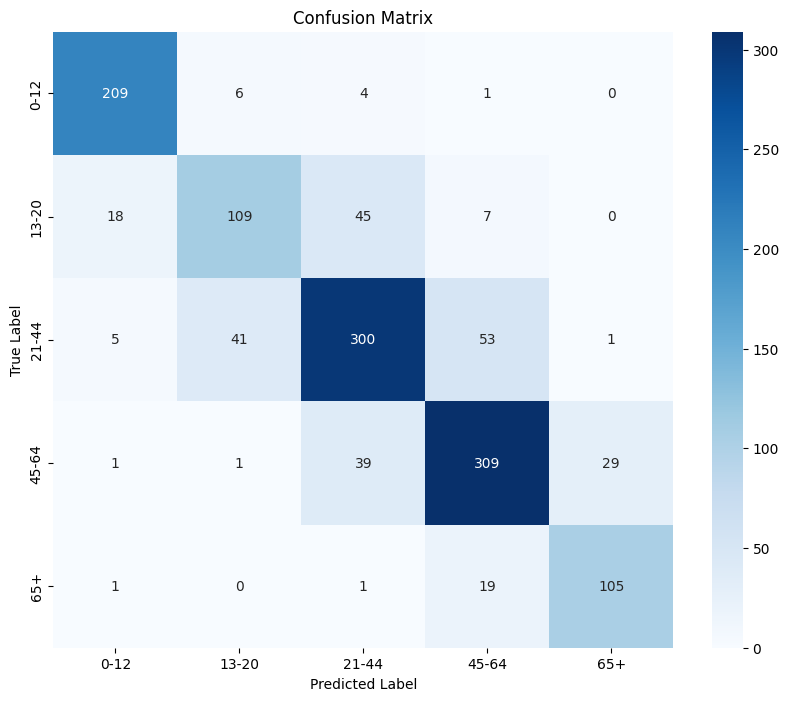


--- Evaluation Complete ---


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names = list(mapping.values())

# Accuracy is a great top-level metric to see overall correctness.
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nOverall Model Accuracy: {accuracy:.4f}")

# A classification report provides a more detailed breakdown per class.
# It shows precision, recall, and F1-score for each class.
print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# --- Step 3: Visualize with a Confusion Matrix ---
# The confusion matrix provides a visual representation of the performance.
# Each row represents the true class, and each column represents the predicted class.
# This helps identify which classes the model is confusing with others.
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Evaluation Complete ---")

In [ ]:
from tqdm import tqdm

corrects = {age: 0 for age in ages}
total = {age: len(os.listdir(os.path.join(test_dir, age))) for age in ages}

mapping = results["0-12"][0].names

for age in ages:
    for result in tqdm(results[age], total=total[age], desc=f"Calculating accuracy for {age} group..."):
        label_index = result.probs.top1
        label = mapping[label_index]
        if label == age:
            corrects[age] += 1
    print(f"{age}: {corrects[age]}/{total[age]} - {corrects[age]/total[age] * 100:.2f}%")
